Visualizer.py file

In [1]:
#!pip install numpy==1.22.4 torch==2.2.2 matplotlib==3.6.2 pandas==2.0.1 scikit_learn==1.1.3 tqdm==4.66.2 setuptools==65.5.0 sympy==1.11.1 seaborn scanpy pykan pyyaml
 










Utils.py file

In [2]:
import torch
import numpy as np
import multiprocessing
import psutil


def configure_system():
    """Configure system settings for optimal performance."""
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.cuda.empty_cache()

    torch.set_num_threads(min(multiprocessing.cpu_count(), 8))


def get_optimal_batch_size(total_samples):
    """
    Determine optimal batch size based on system and data.

    Args:
        total_samples: Total number of samples in dataset

    Returns:
        int: Optimal batch size
    """
    return 256 if torch.cuda.is_available() else min(64, total_samples // 100)


def set_seeds(seed=42):
    """
    Set random seeds for reproducibility.

    Args:
        seed: Random seed value
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_system_info():
    """
    Get system configuration information.

    Returns:
        dict: System information
    """
    info = {
        "cpu_cores": multiprocessing.cpu_count(),
        "ram_gb": psutil.virtual_memory().total / (1024**3),
    }

    if torch.cuda.is_available():
        info.update(
            {
                "gpu": torch.cuda.get_device_name(0),
                "gpu_memory_gb": torch.cuda.get_device_properties(0).total_memory
                / (1024**3),
            }
        )

    return info

Data Processor.py file

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Tuple, List, Dict


class KANDataProcessor1:
    """Processes gene expression data for KAN model training."""

    def __init__(self):
        self.gene_data = {}
        self.sample_names = None
        self.related_genes = {}

    def prepare_training_data(
        self, expression_file: Path, network_file: Path, target_gene: str
    ) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """
        Prepares training data for a target gene.

        Args:
            expression_file: Path to h5ad expression data file
            network_file: Path to network TSV file
            target_gene: Name of target gene

        Returns:
            Tuple of (input matrix, target values, model config)
        """
        # Load and process data
        adata = sc.read_h5ad(expression_file)
        expr_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
        gene_names = adata.var_names.tolist()
        self.sample_names = adata.obs_names.tolist()

        # Get related genes from network
        network_df = pd.read_csv(network_file, sep="\t")
        related_genes = self._get_related_genes(network_df, target_gene, gene_names)
        self.related_genes[target_gene] = related_genes

        # Prepare input matrix and target vector
        X, y = self._prepare_matrices(
            expr_matrix, gene_names, target_gene, related_genes
        )

        # Create model config
        config = {
            "width": [X.shape[1], 1, 1],
            # "width": X.shape[1],
            "grid": 5,
            "k": 4,
            "seed": 42,
            # "feature_names": related_genes,
        }
        # config["feature_names"] = related_genes
        return X.astype(np.float32), y.astype(np.float32), config

    def _get_related_genes(
        self, network_df: pd.DataFrame, target_gene: str, gene_names: List[str]
    ) -> List[str]:
        """Gets list of genes related to target gene from network."""
        source_col, target_col = network_df.columns[:2]
        related = network_df[
            (network_df[source_col] == target_gene)
            | (network_df[target_col] == target_gene)
        ]

        genes = []
        for _, row in related.iterrows():
            gene = (
                row[target_col] if row[source_col] == target_gene else row[source_col]
            )
            if gene in gene_names:
                genes.append(gene)

        return genes

    def _prepare_matrices(
        self,
        expr_matrix: np.ndarray,
        gene_names: List[str],
        target_gene: str,
        related_genes: List[str],
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Prepares input and target matrices."""
        target_idx = gene_names.index(target_gene)
        related_indices = [gene_names.index(gene) for gene in related_genes]

        X = expr_matrix[:, related_indices]
        y = expr_matrix[:, target_idx]

        return X, y

    def get_related_genes(self, target_gene: str) -> List[str]:
        """Returns list of genes related to target gene."""
        return self.related_genes.get(target_gene, [])

KAN Model

In [4]:
a=KANDataProcessor1()
y=a.prepare_training_data(Path("Data/expression_data1.h5ad"), Path("Data/JUN_interactions.tsv"), "JUN")
y

(array([[-0.39712295,  1.0010471 , -0.31169292, ..., -0.3018383 ,
          1.43981   , -0.08644036],
        [-0.39712295,  0.0065413 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        [-0.39712295,  1.1147025 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        ...,
        [-0.39712295, -1.2648143 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        [-0.39712295,  0.89651644, -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        [-0.39712295,  0.7615987 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036]], dtype=float32),
 array([ 0.9646256 ,  0.7348374 ,  0.8462327 , ..., -1.2689325 ,
         1.258737  , -0.02595734], dtype=float32),
 {'width': [18, 1, 1], 'grid': 5, 'k': 4, 'seed': 42})

In [5]:
import kan
from kan import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [6]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch


class KANDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def prepare_data(X, y, batch_size=32):
    # Split indices
    indices = np.random.permutation(len(X))
    train_size = int(0.8 * len(X))
    val_size = int(0.1 * len(X))

    train_idx = indices[:train_size]
    val_idx = indices[train_size : train_size + val_size]
    test_idx = indices[train_size + val_size :]

    # Create datasets
    train_loader = DataLoader(
        KANDataset(X[train_idx], y[train_idx]), batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(KANDataset(X[val_idx], y[val_idx]), batch_size=batch_size)
    test_loader = DataLoader(
        KANDataset(X[test_idx], y[test_idx]), batch_size=batch_size
    )

    return train_loader, val_loader, test_loader

checkpoint directory created: ./model
saving model version 0.0


Training: 100%|█| 2/2 [00:38<00:00, 19.24s/it, train_loss=0.8062, test_loss=0.7784, val_loss=0.7471,


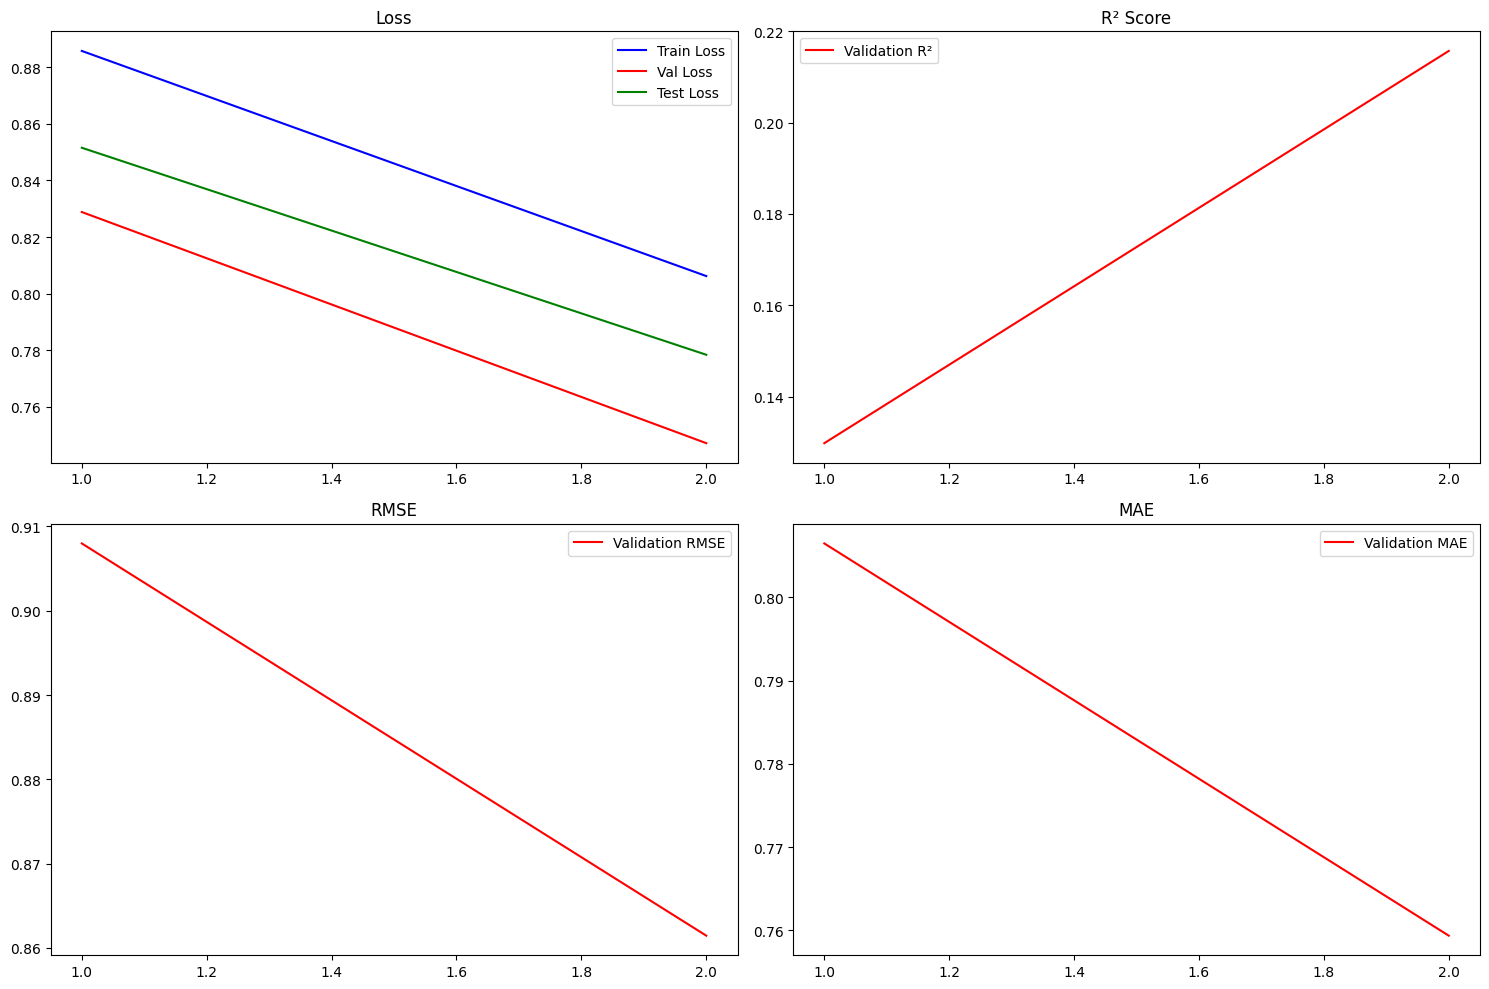

In [ ]:
# Unpack the data
X_data, y_target, config = y

# Create KAN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN(
    width=config["width"],
    grid=config["grid"],
    k=config["k"],
    seed=config["seed"],
    device=device,
)

# Split and create dataloaders
train_loader, val_loader, test_loader = prepare_data(X_data, y_target)

# Training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = torch.nn.MSELoss()
epochs = 100


def r2_score(y_true, y_pred):
    total_sum_squares = torch.sum((y_true - torch.mean(y_true)) ** 2)
    residual_sum_squares = torch.sum((y_true - y_pred) ** 2)
    return 1 - (residual_sum_squares / total_sum_squares)


def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    criterion,
    epochs,
    patience=5,
    min_delta=1e-4,
):
    best_val_loss = float("inf")
    patience_counter = 0
    history = []

    pbar = tqdm(range(epochs), desc="Training", ncols=100, position=0, leave=True)
    for epochs in pbar:
        # Training phase
        model.train()
        train_loss, train_r2, train_rmse, train_mae = 0, 0, 0, 0
        for X_batch, y_batch in train_loader:
            loss = train_batch(model, X_batch, y_batch, optimizer, criterion)
            train_loss += loss

        # Validation phase
        model.eval()
        val_loss, val_r2, val_rmse, val_mae = 0, 0, 0, 0
        test_loss, test_r2, test_rmse, test_mae = 0, 0, 0, 0

        with torch.no_grad():
            for X, y in val_loader:
                predictions = model(X.to(device)).squeeze()
                y = y.to(device)
                val_loss += criterion(predictions, y).item()
                val_r2 += r2_score(y, predictions)
                val_rmse += rmse(y, predictions)
                val_mae += mae(y, predictions)

            for X, y in test_loader:
                predictions = model(X.to(device)).squeeze()
                y = y.to(device)
                test_loss += criterion(predictions, y).item()
                test_r2 += r2_score(y, predictions)
                test_rmse += rmse(y, predictions)
                test_mae += mae(y, predictions)

        # Normalize metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        test_loss /= len(test_loader)
        val_r2 /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        test_r2 /= len(test_loader)
        test_rmse /= len(test_loader)
        test_mae /= len(test_loader)

        # Store metrics
        history.append((train_loss, val_loss, test_loss, val_r2,val_rmse, val_mae))

        # Update progress bar
        pbar.set_postfix(
            {
                "train_loss": f"{train_loss:.4f}",
                "test_loss": f"{test_loss:.4f}",
                "val_loss": f"{val_loss:.4f}",
                "val_r2": f"{val_r2:.4f}",
                "val_rmse": f"{val_rmse:.4f}",
            }
        )

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("\nEarly stopping triggered")
            model.load_state_dict(torch.load("best_model.pt"))
            break

    return history


def train_batch(model, X, y, optimizer, criterion):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output.squeeze(), y)
    loss.backward()
    optimizer.step()
    return loss.item()


def plot_training_metrics(history):
    epochs = np.array(range(1, len(history) + 1))
    metrics = [
        np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in m])
        for m in zip(*history)
    ]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss Plot
    ax1.plot(epochs, metrics[0], "b-", label="Train Loss")
    ax1.plot(epochs, metrics[1], "r-", label="Val Loss")
    ax1.plot(epochs, metrics[2], "g-", label="Test Loss")
    ax1.set_title("Loss")
    ax1.legend()

    # R² Plot
    ax2.plot(epochs, metrics[3], "r-", label="Validation R²")
    ax2.set_title("R² Score")
    ax2.legend()

    # RMSE Plot
    ax3.plot(epochs, metrics[4], "r-", label="Validation RMSE")
    ax3.set_title("RMSE")
    ax3.legend()

    # MAE Plot
    ax4.plot(epochs, metrics[5], "r-", label="Validation MAE")
    ax4.set_title("MAE")
    ax4.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()


# Usage
history = train_with_early_stopping(
    model, train_loader, val_loader, test_loader,optimizer, criterion, epochs
)
plot_training_metrics(history)

In [ ]:
model.auto_symbolic()

In [ ]:
model.symbolic_formula()[0][0]

In [ ]:
model.plot()

In [ ]:
def analyze_kan_feature_contributions(model, X_tensor, feature_names):
    model.eval()
    contributions = {}

    weights = model.state_dict()
    print("Weights shapes:")
    print("act_weights shape:", weights["act_fun.0.coef"].shape)
    print("sym_weights shape:", weights["symbolic_fun.0.affine"].shape)
    print("X_tensor shape:", X_tensor.shape)
    print("Number of features:", len(feature_names))

    act_weights = weights["act_fun.0.coef"].cpu().numpy()   #Non-linear contribution
    sym_weights = weights["symbolic_fun.0.affine"].cpu().numpy() #Linear contribution

    for i in range(X_tensor.shape[1]):
        w_impact = np.abs(sym_weights[0, i, :]).mean()  # Adjusted for shape (1, 18, 4)
        a_impact = np.abs(act_weights[i, :, :]).mean()  # Adjusted for shape (18, 1, 7)
        contributions[feature_names[i]] = float(w_impact + a_impact)

    # Normalize and filter
    total = sum(contributions.values())
    contributions = {k: v / total for k, v in contributions.items() if v / total > 0.001}

    # Plot
    plt.figure(figsize=(12, 6))
    names = list(contributions.keys())
    values = list(contributions.values())
    plt.bar(names, values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Feature Contributions Based on Model Weights")
    plt.tight_layout()
    plt.show()

    return dict(sorted(contributions.items(), key=lambda x: x[1], reverse=True))

In [ ]:
# Load data
network_df = pd.read_csv("Data/JUN_interactions.tsv", sep="\t")
adata = sc.read_h5ad("Data/expression_data1.h5ad")
gene_names = adata.var_names.tolist()

# Get related genes
a = KANDataProcessor1()
X_data, y_target, config = a.prepare_training_data(
    Path("Data/expression_data1.h5ad"), Path("Data/JUN_interactions.tsv"), "JUN"
)
related_genes = a.get_related_genes("JUN")

# Create input tensor
X_tensor = torch.FloatTensor(X_data).to(device)


# Load model with correct map_location
checkpoint = torch.load("best_model.pt", map_location="cpu")
model.load_state_dict(checkpoint)

# Then move model to device
model = model.to(device)
X_tensor = X_tensor.to(device)
contributions = analyze_kan_feature_contributions(model, X_tensor, related_genes)